In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

2023-07-26 15:45:38.909580: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def clean_gene(df, column):
    # Copy the dataframe to avoid modifying the original
    df = df.copy()

    # Replace hyphen '-' and '(' ')' with nothing
    df[column] = df[column].str.replace(r'[-\(\)\'\?\_]', '', regex=True)

    # Convert all upper case to lower case
    df[column] = df[column].str.lower()

    return df


In [3]:
val_data = pd.read_csv("refgenes.csv")
val_data.head(10)

,Gene family,Scope,Type,Class,Subclass
0,16S,core,AMR,TETRACYCLINE,TETRACYCLINE
1,16S,core,AMR,AMINOGLYCOSIDE,GENTAMICIN C/NEOMYCIN/PAROMOMYCIN
2,16S,core,AMR,EDEINE,EDEINE
3,16S,core,AMR,AMINOGLYCOSIDE,KASUGAMYCIN
4,16S,core,AMR,AMINOGLYCOSIDE,KASUGAMYCIN
5,16S,core,AMR,AMINOGLYCOSIDE,KASUGAMYCIN
6,16S,core,AMR,AMINOGLYCOSIDE,STREPTOMYCIN
7,16S,core,AMR,AMINOGLYCOSIDE,KASUGAMYCIN
8,16S,core,AMR,AMINOGLYCOSIDE,KASUGAMYCIN
9,16S,core,AMR,TETRACYCLINE,TETRACYCLINE


In [4]:
val_data.drop('Class', axis=1, inplace=True)
val_data.drop('Scope', axis=1, inplace=True)
val_data.drop('Type', axis=1, inplace=True)
val_data.drop_duplicates(inplace=True)
val_data['Subclass'] = val_data['Subclass'].str.lower()
val_data['Subclass'] = val_data['Subclass'].str.split('/')
val_data = val_data.explode('Subclass')
val_data['Gene family'] = val_data['Gene family'].str.split('/')
val_data = val_data.explode('Gene family')
val_data.drop_duplicates(inplace=True)
val_data.dropna(inplace=True)
val_data.reset_index(drop=True, inplace=True)
val_data = clean_gene(val_data,'Gene family')
val_data.drop_duplicates(inplace=True)
val_data

,Gene family,Subclass
0,16s,tetracycline
1,16s,gentamicin c
2,16s,neomycin
3,16s,paromomycin
4,16s,edeine
...,...,...
1397,uhpa,fosfomycin
1398,uhpt,fosfomycin
1399,walk,daptomycin
1400,yciv,trimethoprim-sulfamethoxazole


In [5]:
val_data.to_csv("val_data.csv", index=False)

In [6]:
data = pd.read_csv(r'isolates.csv')
data.head(10)

,#Organism group,Isolate,AMR genotypes,AST phenotypes
0,Listeria monocytogenes,PDT000077416.3,"fosX=COMPLETE,lin=COMPLETE","chloramphenicol=S,clindamycin=R,erythromycin=S..."
1,Listeria monocytogenes,PDT000095192.3,"fosX=COMPLETE,lin=COMPLETE","ampicillin=S,penicillin=S"
2,Salmonella enterica,PDT000003687.3,"mdsA=COMPLETE,mdsB=COMPLETE","amikacin=S,amoxicillin-clavulanic acid=S,ampic..."
3,Salmonella enterica,PDT000003688.4,"mdsA=COMPLETE,mdsB=COMPLETE","amikacin=S,amoxicillin-clavulanic acid=S,ampic..."
4,Salmonella enterica,PDT000003689.4,"mdsA=COMPLETE,mdsB=COMPLETE","amikacin=S,amoxicillin-clavulanic acid=S,ampic..."
5,Salmonella enterica,PDT000003690.3,"aph(3'')-Ib=COMPLETE,aph(6)-Id=COMPLETE,mdsA=C...","amikacin=S,amoxicillin-clavulanic acid=S,ampic..."
6,Salmonella enterica,PDT000003691.3,"mdsA=COMPLETE,mdsB=COMPLETE,tet(B)=COMPLETE","amikacin=S,amoxicillin-clavulanic acid=S,ampic..."
7,Salmonella enterica,PDT000003692.3,"mdsA=COMPLETE,mdsB=COMPLETE","amikacin=S,amoxicillin-clavulanic acid=S,ampic..."
8,Salmonella enterica,PDT000003693.3,"aph(3'')-Ib=COMPLETE,aph(6)-Id=COMPLETE,mdsA=C...","amikacin=S,amoxicillin-clavulanic acid=S,ampic..."
9,Salmonella enterica,PDT000003694.4,"fosA7=COMPLETE,mdsA=COMPLETE,mdsB=COMPLETE","amikacin=S,amoxicillin-clavulanic acid=S,ampic..."


In [7]:
anti_family = pd.read_csv("anti_family.csv")
anti_family.head(10)

/var/folders/jp/2wr1hx0s4zjdcnf63gtk75fw0000gq/T/ipykernel_28440/3504613261.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  anti_family = pd.read_csv("anti_family.csv")


,gene family,gene,antibiotic,drug_class,S,R
0,ANT(2''),ANT(2'')-Ia,spectinomycin,aminoglycoside,NaN,1.0
1,ANT(2''),ANT(2'')-Ia,trimethoprim-sulfamethoxazole,diaminopyrimidine,NaN,NaN
2,ANT(2''),ANT(2'')-Ia,azithromycin,macrolide,NaN,NaN
3,ANT(2''),ANT(2'')-Ia,ceftazidime-avibactam,beta-lactamase,NaN,NaN
4,ANT(2''),ANT(2'')-Ia,piperacillin,Penicillin,NaN,NaN
5,ANT(2''),ANT(2'')-Ia,ticarcillin,Penicillin,NaN,NaN
6,ANT(2''),ANT(2'')-Ia,kanamycin,Aminoglycoside,NaN,1.0
7,ANT(2''),ANT(2'')-Ia,oxacillin,Penicillin,NaN,NaN
8,ANT(2''),ANT(2'')-Ia,tedizolid,Oxazolidinone,NaN,NaN
9,ANT(2''),ANT(2'')-Ia,cefiderocol,beta-lactamase,NaN,NaN


In [8]:
# gene_anti_R = pd.read_csv("gene_anti_R.csv")
# gene_anti_R.head(10)

In [9]:
# anti_family.loc[anti_family['antibiotic'].str.contains('trimethoprim'), 'R'] = None
# merged_df = anti_family.merge(gene_anti_R, left_on='gene', right_on='aro_term', how='left')
# merged_df.drop_duplicates(inplace=True)
# merged_df.to_csv('merged_df.csv', index=False)
# # Check if there is any row where both 'drug_class_x' and 'drug_class_y' contain 'diaminopyrimidine'
# diaminopyrimidine_rows = (merged_df['drug_class_x'].str.contains('diaminopyrimidine') & merged_df['drug_class_y'].str.contains('diaminopyrimidine'))
#
# # Filter 'anti_family' to get rows matching the condition
# matched_rows = anti_family[anti_family['gene'].isin(merged_df.loc[diaminopyrimidine_rows, 'gene'])]
#
# # Update the 'R' and 'S' columns for matched rows in 'anti_family'
# anti_family.loc[matched_rows.index, 'R'] = 1
# anti_family.loc[matched_rows.index, 'S'] = None
# anti_family.to_csv("anti_family.csv",index=False)

In [10]:
# gene_anti_R.drop('prevalence_sequence_id', axis=1, inplace=True)
# gene_anti_R.drop('model_id', axis=1, inplace=True)
# gene_anti_R.drop('aro_accession', axis=1, inplace=True)
# gene_anti_R.drop('detection_model', axis=1, inplace=True)
# gene_anti_R.drop('species_name', axis=1, inplace=True)
# gene_anti_R.drop('ncbi_accession', axis=1, inplace=True)
# gene_anti_R.drop('data_type', axis=1, inplace=True)
# gene_anti_R.drop('rgi_criteria', axis=1, inplace=True)
# gene_anti_R.drop('percent_identity', axis=1, inplace=True)
# gene_anti_R.drop('bitscore', axis=1, inplace=True)
# gene_anti_R.drop('amr_gene_family', axis=1, inplace=True)
# gene_anti_R.drop('resistance_mechanism', axis=1, inplace=True)
# val_data.drop_duplicates(inplace=True)
# gene_anti_R.to_csv("gene_anti_R.csv", index=False)

In [11]:
anti_family = clean_gene(anti_family,'gene')
anti_family

,gene family,gene,antibiotic,drug_class,S,R
0,ANT(2''),ant2ia,spectinomycin,aminoglycoside,NaN,1.0
1,ANT(2''),ant2ia,trimethoprim-sulfamethoxazole,diaminopyrimidine,NaN,NaN
2,ANT(2''),ant2ia,azithromycin,macrolide,NaN,NaN
3,ANT(2''),ant2ia,ceftazidime-avibactam,beta-lactamase,NaN,NaN
4,ANT(2''),ant2ia,piperacillin,Penicillin,NaN,NaN
...,...,...,...,...,...,...
264379,NaN,mcr2.3,ceftazidime,beta-lactamase,NaN,NaN
264380,NaN,mcr2.3,amoxicillin-clavulanic acid,beta-lactamase,NaN,NaN
264381,NaN,mcr2.3,streptomycin,Aminoglycoside,NaN,NaN
264382,NaN,mcr2.3,moxifloxacin,Quinolone,NaN,NaN


In [12]:
def transform_dataframe(df):
    new_data = []

    for idx, row in df.iterrows():
        # split AMR genotypes and remove "=COMPLETE"
        amr_genotypes = [pheno.split('=')[0] for pheno in row['AMR genotypes'].split(',') if '=POINT' not in pheno]

        # split AST phenotypes and remove "=POINT"
        ast_phenotypes = row['AST phenotypes'].split(',')

        # process each phenotype
        for pheno in ast_phenotypes:
            drug, resistance = pheno.split('=')
            if resistance == 'R':
                resistance_score = 1
            elif resistance == 'S':
                resistance_score = 0
            else:  # assuming 'I' as per your description
                resistance_score = 0.5

            # create a new row
            new_row = {'#Organism group': row['#Organism group'],
                       'Isolate': row['Isolate'],
                       'AMR genotypes': ', '.join(amr_genotypes),
                       'drug': drug,
                       'resistance': resistance_score}
            new_data.append(new_row)

    # create a new dataframe
    new_df = pd.DataFrame(new_data)

    return new_df


In [13]:
df = transform_dataframe(data)


In [14]:
df.to_csv("BasicData.csv",index=False)
df.head(10)

,#Organism group,Isolate,AMR genotypes,drug,resistance
0,Listeria monocytogenes,PDT000077416.3,"fosX, lin",chloramphenicol,0.0
1,Listeria monocytogenes,PDT000077416.3,"fosX, lin",clindamycin,1.0
2,Listeria monocytogenes,PDT000077416.3,"fosX, lin",erythromycin,0.0
3,Listeria monocytogenes,PDT000077416.3,"fosX, lin",gentamicin,0.0
4,Listeria monocytogenes,PDT000077416.3,"fosX, lin",levofloxacin,0.0
5,Listeria monocytogenes,PDT000077416.3,"fosX, lin",oxacillin,1.0
6,Listeria monocytogenes,PDT000077416.3,"fosX, lin",penicillin,0.0
7,Listeria monocytogenes,PDT000077416.3,"fosX, lin",rifampin,0.0
8,Listeria monocytogenes,PDT000077416.3,"fosX, lin",tetracycline,0.0
9,Listeria monocytogenes,PDT000077416.3,"fosX, lin",trimethoprim-sulfamethoxazole,0.0


In [15]:
df = clean_gene(df, 'AMR genotypes')
df

,#Organism group,Isolate,AMR genotypes,drug,resistance
0,Listeria monocytogenes,PDT000077416.3,"fosx, lin",chloramphenicol,0.0
1,Listeria monocytogenes,PDT000077416.3,"fosx, lin",clindamycin,1.0
2,Listeria monocytogenes,PDT000077416.3,"fosx, lin",erythromycin,0.0
3,Listeria monocytogenes,PDT000077416.3,"fosx, lin",gentamicin,0.0
4,Listeria monocytogenes,PDT000077416.3,"fosx, lin",levofloxacin,0.0
...,...,...,...,...,...
316066,Enterobacter roggenkampii,PDT000898827.2,"blamir, cata, fosa, mcr10.1, oqxa, oqxb",tetracycline,0.0
316067,Enterobacter roggenkampii,PDT000898827.2,"blamir, cata, fosa, mcr10.1, oqxa, oqxb",trimethoprim-sulfamethoxazole,0.0
316068,Enterobacter roggenkampii,PDT001161812.2,"blamir16, cata, fosa, oqxb",ertapenem,0.0
316069,Enterobacter roggenkampii,PDT001161812.2,"blamir16, cata, fosa, oqxb",imipenem,0.5


In [16]:
print((df['resistance'] == 0.5).sum())

10661


In [17]:
df.to_csv("BasicData_clean.csv",index=False)

In [18]:
def create_empty_gene_antibiotic_df(df):
    unique_all_genes = []
    unique_all_antibiotics = []

    for idx, row in df.iterrows():
        genotypes = row['AMR genotypes'].split(', ')
        antibiotic = row['drug']

        unique_all_genes.extend(genotypes)
        unique_all_antibiotics.append(antibiotic)

    unique_all_genes = list(set(unique_all_genes))  # Convert to list
    unique_all_antibiotics = list(set(unique_all_antibiotics))  # Convert to list

    gene_antibiotic_df = pd.DataFrame(index=unique_all_genes, columns=unique_all_antibiotics)
    gene_antibiotic_df = gene_antibiotic_df.fillna(-1)

    return gene_antibiotic_df, unique_all_antibiotics, unique_all_genes

# Assuming your DataFrame is named 'new_dataframe'
gene_antibiotic_df, unique_all_antibiotics, unique_all_genes = create_empty_gene_antibiotic_df(df)
gene_antibiotic_df


,ceftiofur,cefalexin,doxycycline,neomycin,ticarcillin,rifampin,zoliflodacin,fosfomycin-glucose-6-phosphate,ampicillin-sulbactam,chloramphenicol,...,imipenem-relebactam,erythromycin,carbenicillin,mupirocin,enrofloxacin,colistin,plazomicin,ciprofloxacin,vancomycin,Imipenem-EDTA-PA
blapdc19b,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
ant6ia,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
blaoxa120,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
mefc,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
blaec,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
blapme1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
blalen9,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
blapdc103,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
blaact66,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [19]:
gene_antibiotic_df.shape

(968, 114)

In [21]:
from collections import Counter

antibiotic_counts = Counter(unique_all_antibiotics)

# Find the duplicates (drugs with count greater than 1)
duplicates = [antibiotic for antibiotic, count in antibiotic_counts.items() if count > 1]

if len(duplicates) > 0:
    # Duplicates are present in 'unique_all_antibiotics'
    print("Duplicate drugs:", duplicates)
else:
    # No duplicates found
    print("No duplicates.")
print(len(unique_all_antibiotics))

No duplicates.
114


In [22]:
gene_antibiotic_df.to_csv("Empty_Gene_Antibiotic.csv", index=True, index_label=False)

***********************************************

### run from here

In [23]:
# def gene_per_drug(drug):
#     drug_df = df[df['drug'] == drug]
#     unique_genes = set()
#     for genes in drug_df['AMR genotypes'].str.split(', '):
#         unique_genes.update(genes)
#     return drug_df, unique_genes

In [241]:
df = pd.read_csv('BasicData_clean.csv')
val_data = pd.read_csv('val_data.csv')
gene_antibiotic_df = pd.read_csv('Empty_Gene_Antibiotic.csv')
anti_family = clean_gene(anti_family,'gene')

In [242]:
gene_antibiotic_df

,ceftiofur,cefalexin,doxycycline,neomycin,ticarcillin,rifampin,zoliflodacin,fosfomycin-glucose-6-phosphate,ampicillin-sulbactam,chloramphenicol,...,imipenem-relebactam,erythromycin,carbenicillin,mupirocin,enrofloxacin,colistin,plazomicin,ciprofloxacin,vancomycin,Imipenem-EDTA-PA
blapdc19b,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
ant6ia,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
blaoxa120,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
mefc,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
blaec,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
blapme1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
blalen9,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
blapdc103,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
blaact66,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [243]:
def gene_per_drug(drug):
    drug_df = df[df['drug'] == drug]
    unique_genes = set()
    for genes in drug_df['AMR genotypes'].str.split(', '):
        unique_genes.update(genes)
    return drug_df,unique_genes
    # # Get unique #Organism group values
    # organism_groups = drug_df['#Organism group'].unique()
    #
    # # Initialize empty lists for train_df and test_df
    # train_dfs = []
    # test_dfs = []
    #
    # # Iterate over #Organism groups
    # for group in organism_groups:
    #     group_df = drug_df[drug_df['#Organism group'] == group]
    #
    #     if len(group_df) > 1:
    #         group_train_df, group_test_df = train_test_split(group_df, test_size=0.2, random_state=42)
    #     else:
    #         group_train_df = group_df
    #         group_test_df = group_df
    #
    #     train_dfs.append(group_train_df)
    #     test_dfs.append(group_test_df)
    #
    # # Concatenate the train and test dataframes for all groups
    # train_df = pd.concat(train_dfs)
    # test_df = pd.concat(test_dfs)
    #
    # return train_df, test_df, unique_genes

# Rest of the code remains the same


In [244]:
def relevant_val_df(drug,unique_genes):
    relevant_df = val_data[(val_data['Subclass'] == drug) & (val_data['Gene family'].isin(unique_genes))]
    if relevant_df.shape[0]>1 :
        return relevant_df
    return None

In [245]:
# def create_gene_df(drug_df,val_df, unique_genes):
#     gene_arrays = []
#     labels = []
#
#     for idx, row in drug_df.iterrows():
#         gene_array = np.zeros(len(unique_genes), dtype=int)
#         genes = row['AMR genotypes'].split(', ')
#         for gene in genes:
#             gene_index = list(unique_genes).index(gene)
#             gene_array[gene_index] = 1
#
#         gene_arrays.append(gene_array.tolist())
#         labels.append(row['resistance'])
#
#     gene_df = pd.DataFrame(gene_arrays, columns=unique_genes)
#     gene_df['label'] = labels
#
#     if val_df is not None:
#         for idx, row in val_df.iterrows():
#             gene_array = np.zeros(len(unique_genes), dtype=int)
#             gene = row['Gene family']
#             gene_index = list(unique_genes).index(gene)
#             gene_array[gene_index] = 1
#
#             gene_arrays.append(gene_array.tolist())
#             labels.append(1)
#
#         gene_df = pd.DataFrame(gene_arrays, columns=unique_genes)
#         gene_df['label'] = labels
#
#     return gene_df.sample(frac=1).reset_index(drop=True)

In [246]:

def create_update_gene_df(drug_df, unique_genes, drug):
    gene_arrays = []
    labels = []
    drug_r = set(anti_family.loc[(anti_family['antibiotic'] == drug) & (anti_family['R'] == 1), 'gene'].tolist())
    for _, row in drug_df.iterrows():
        genes = row['AMR genotypes'].split(', ')
        label = row['resistance']
        gene_array = np.zeros(len(unique_genes), dtype=int)

        for gene in genes:
            gene_index = list(unique_genes).index(gene)
            if gene in drug_r:
                gene_array[gene_index] = 1

        gene_arrays.append(gene_array.tolist())
        labels.append(label)
    gene_df = pd.DataFrame(gene_arrays, columns=unique_genes)
    gene_df['label'] = labels

    # if val_df is not None:
    #     for idx, row in val_df.iterrows():
    #         gene_array = np.zeros(len(unique_genes), dtype=int)
    #         gene = row['Gene family']
    #         gene_index = list(unique_genes).index(gene)
    #         gene_array[gene_index] = 1
    #
    #         gene_arrays.append(gene_array.tolist())
    #         labels.append(1)
    #
    #     gene_df = pd.DataFrame(gene_arrays, columns=unique_genes)
    #     gene_df['label'] = labels

    zero_col = [col for col in gene_df.columns if col not in drug_r and col != 'label']
    gene_df = gene_df.drop(zero_col, axis=1)
    # if len(zero_col) == 0:
    #     zero_col = [col for col in gene_df.columns if col not in drug_r and col != 'label']
    # else:
    #     zero_col = [col for col in zero_col if col not in drug_r and col != 'label']
    # gene_df = gene_df.drop(zero_col, axis=1)
    return gene_df.sample(frac=1).reset_index(drop=True)

In [247]:
# def update_df(df, drug, anti_family, zero_col):
#     # Get the list of genes for which the antibiotic is the specified drug
#     drug_r = anti_family.loc[(anti_family['antibiotic'] == drug) & (anti_family['R'] == 1), 'gene'].tolist()
#     drug_s = anti_family.loc[(anti_family['antibiotic'] == drug) & (anti_family['R'] != 1) & (anti_family['S'] == 's'), 'gene'].tolist()
#
#     # Iterate over each row
#     for index, row in df.iterrows():
#         # Iterate over each column
#         for column in df.columns:
#             gene = str(column)
#             if gene == "label":
#                 continue
#             # Check if the gene is not in the list of drug genes and label is 1 or 0.5
#             if ((gene not in drug_r) or (gene in drug_s)) and (row['label'] == 1):
#                 # Set the value to 0 if the condition is met
#                 df.loc[index, column] = 0
#
#             # Check if the gene is in the list of drug genes and label is 0
#             if (gene in drug_r) and (row['label'] == 0):
#                 df.loc[index, column] = 0
#
#             if (gene in drug_s) and (row['label'] == 0):
#                 df.loc[index, column] = 1
#
#
#
#     if len(zero_col)==0:
#         zero_col = df.columns[df.eq(0).all(axis=0)]
#     df = df.drop(zero_col, axis=1)
#     return df, zero_col


In [248]:
def Model_deep(drug_train_for_model, epochs, batch_size):
    # Assuming your DataFrame with gene features and labels is named `oxacillin_df_for_model`
    # Split the data into training features (genes) and labels
    X_train = drug_train_for_model.drop('label', axis=1).values
    y_train = drug_train_for_model['label'].values


    # Define the neural network model
    model = keras.Sequential()
    model.add(keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.Dense(1, activation='sigmoid'))  # Sigmoid activation for probability between 0 and 1

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['mse'])

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)

    # Make predictions on the training data
    pred = model.predict(X_train)

    # Display loss and mse (mse on training data, as we are not using separate test data)
    loss, mse = model.evaluate(X_train, y_train)
    print('Loss:', loss)
    print('Mean Squared Error:', mse)
    print('Shape of predictions:', pred.shape)
    print('Shape of y_train:', y_train.shape)

    # Make predictions
    return y_train, pred, model


In [249]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def Model(drug_train_for_model, drug_test_for_model):
    # Split the data into training features (genes) and labels
    X_train = drug_train_for_model.drop('label', axis=1).values
    y_train = drug_train_for_model['label'].values

    # Split the data into testing features (genes) and labels
    X_test = drug_test_for_model.drop('label', axis=1).values
    y_test = drug_test_for_model['label'].values

    # Initialize the model
    model = RandomForestRegressor(n_estimators=100, random_state=0)

    # Train the model
    model.fit(X_train, y_train)

    # Predict the resistance score
    y_pred = model.predict(X_test)

    # Compute mean squared error
    mse = mean_squared_error(y_test, y_pred)

    print('Mean Squared Error:', mse)
    print('len of pred:', y_pred.shape, 'y_test:', y_test.shape)

    # Make predictions
    return y_test, y_pred, model

In [250]:
def evaluation(y_test, predictions, drug):
    # Calculate mean squared error
    mse = mean_squared_error(y_test, predictions)

    # Calculate mean absolute error
    mae = mean_absolute_error(y_test, predictions)

    # Calculate R^2 score
    r2 = r2_score(y_test, predictions)


    print('Mean Squared Error:', mse)
    print('Mean Absolute Error:', mae)
    print('R^2 Score:', r2)
    return mse, mae, r2


In [251]:
def Create_df_one_gene(drug_df_for_model):
    # Extract the column names (excluding the label column)
    column_names = drug_df_for_model.columns[:-1]

    # Create a new DataFrame with zeros
    df_one_gene = pd.DataFrame(0, index=np.arange(len(column_names)), columns=column_names)

    # Set the value at the corresponding index position in each row
    for i in range(len(column_names)):
        df_one_gene.iloc[i, i] = 1

    # Display the new DataFrame
    return df_one_gene

In [35]:
# it will save the drugs with empty df_gene
problematic_drugs = []

In [36]:
def PredR_Antibiotic(drug,drug_val_dict):
    print('************************\n', drug)
    drug_r = anti_family.loc[(anti_family['antibiotic'] == drug) & (anti_family['R'] == 1), 'gene'].tolist()
    drug_df,drug_genes = gene_per_drug(drug)
    drug_train_for_model = create_update_gene_df(drug_df,list(drug_genes), drug)
    val_drug= relevant_val_df(drug, drug_genes)
    if val_drug is not None:
        drug_val_dict[drug] = val_drug
    y_train, predictions, model = Model_deep(drug_train_for_model, 40, 10)
    df_gene = Create_df_one_gene(drug_train_for_model)
    if df_gene.shape[1]>1:
     pred = model.predict(df_gene)
    else:
        problematic_drugs.append(drug)

    for col in drug_genes:
        if (df_gene.shape[1]>1) and (col in drug_r):
         gene_antibiotic_df.loc[col, drug] = pred[df_gene.columns.get_loc(col)]
        else:
          gene_antibiotic_df.loc[col, drug] = 0.0


In [37]:
antibiotic_few_samples = []
antibiotic_done = []
drug_val_dict = {}
for antibiotic in unique_all_antibiotics:
    if len(df[df['drug'] == antibiotic]) < 50:
        antibiotic_few_samples.append(antibiotic)
        continue
    PredR_Antibiotic(antibiotic,drug_val_dict)
    antibiotic_done.append(antibiotic)
    gene_antibiotic_df.to_csv("Gene_Antibiotic_26_07.csv", index=True, index_label=False)

************************
 ceftiofur
Epoch 1/40
486/486 [==============================] - 3s 3ms/step - loss: 0.4420 - mse: 0.1340
Epoch 2/40
486/486 [==============================] - 1s 2ms/step - loss: 0.4329 - mse: 0.1303
Epoch 3/40
486/486 [==============================] - 1s 3ms/step - loss: 0.4336 - mse: 0.1303
Epoch 4/40
486/486 [==============================] - 1s 2ms/step - loss: 0.4327 - mse: 0.1301
Epoch 5/40
486/486 [==============================] - 1s 3ms/step - loss: 0.4304 - mse: 0.1295
Epoch 6/40
486/486 [==============================] - 1s 1ms/step - loss: 0.4327 - mse: 0.1301
Epoch 7/40
486/486 [==============================] - 1s 1ms/step - loss: 0.4302 - mse: 0.1294
Epoch 8/40
486/486 [==============================] - 1s 1ms/step - loss: 0.4317 - mse: 0.1298
Epoch 9/40
486/486 [==============================] - 1s 1ms/step - loss: 0.4314 - mse: 0.1296
Epoch 10/40
486/486 [==============================] - 1s 1ms/step - loss: 0.4310 - mse: 0.1296
Epoch 11/40
4

In [252]:
import pandas as pd

def logical_prediction(gene_data, train_data):
    # Initialize an empty list to store the predictions for each gene
    predictions = []

    # Loop through each gene in the gene_data
    for gene in gene_data:
        # Get the rows in the train_data where the entry of the current gene is 1
        relevant_rows = train_data[train_data[gene] == 1]

        # Calculate the percentage of rows that have label 1
        if len(relevant_rows) == 0:
            # If there are no rows with the current gene, prediction is 0
            prediction = 0
        else:
            percentage_label_1 = relevant_rows['label'].mean()

            # Round the percentage to two decimal places for cleaner output
            prediction = round(percentage_label_1, 2)

        # Append the prediction to the list of predictions
        predictions.append(prediction)

    # Create a pandas Series with the gene_data as the index and predictions as the values
    predictions_series = pd.Series(predictions, index=gene_data)

    return predictions_series


In [253]:

def Insert_values_FinalTable(drug,drug_val_dict):
    print('************************\n', drug)
    drug_df,drug_genes = gene_per_drug(drug)
    drug_train_for_model = create_update_gene_df(drug_df,list(drug_genes), drug)
    gene_data = [col for col in drug_train_for_model.columns if col != 'label']
    val_drug= relevant_val_df(drug, drug_genes)
    if val_drug is not None:
        drug_val_dict[drug] = val_drug
    van_pred = logical_prediction(gene_data,drug_train_for_model)
    for col in drug_genes:
            if (col in gene_data):
             gene_antibiotic_df.loc[col, drug] = van_pred[col]
            else:
              gene_antibiotic_df.loc[col, drug] = 0.0


In [254]:
antibiotic_few_samples = []
antibiotic_done = []
drug_val_dict = {}
for antibiotic in unique_all_antibiotics:
    if len(df[df['drug'] == antibiotic]) < 50:
        antibiotic_few_samples.append(antibiotic)
        continue
    Insert_values_FinalTable(antibiotic,drug_val_dict)
    antibiotic_done.append(antibiotic)
    gene_antibiotic_df.to_csv("Gene_Antibiotic_02_08.csv", index=True, index_label=False)

************************
 ceftiofur
************************
 doxycycline
************************
 rifampin
************************
 zoliflodacin
************************
 ampicillin-sulbactam
************************
 chloramphenicol
************************
 ceftolozane-tazobactam
************************
 ampicillin
************************
 streptomycin
************************
 azithromycin
************************
 cefazolin
************************
 ticarcillin-clavulanic acid
************************
 aztreonam
************************
 tobramycin
************************
 telithromycin
************************
 cefuroxime
************************
 amikacin
************************
 daptomycin
************************
 ceftazidime-clavulanic acid
************************
 cefotaxime
************************
 synercid
************************
 polymyxin B
************************
 amoxicillin
************************
 fosfomycin
************************
 tetracycline
*********

In [201]:
for drug, val_drug in drug_val_dict.items():
    print('************************\n', drug)
    drug_df,drug_genes = gene_per_drug(drug)
    drug_train_for_model = create_update_gene_df(drug_df,list(drug_genes), drug)
    gene_data = [col for col in drug_train_for_model.columns if col != 'label']
    val_drug= relevant_val_df(drug, drug_genes)
    van_pred = logical_prediction(gene_data,drug_train_for_model)
   # Threshold the predicted probabilities
    Y_pred = pd.Series(np.where(van_pred >= 0.7, 1, 0), index=van_pred.index)


    Y_true = pd.Series(1, index=val_drug['Gene family'])

    # Find the number of True Positives (TP)
    true_positives = sum((Y_pred == 1) & (Y_true == 1))

    # Calculate Recall
    recall = true_positives / sum(Y_true == 1)
    print("Recall:", recall)

************************
 chloramphenicol
Recall: 0.23076923076923078
************************
 streptomycin
Recall: 0.6
************************
 azithromycin
Recall: 0.0
************************
 tobramycin
Recall: 0.8333333333333334
************************
 amikacin
Recall: 0.5
************************
 fosfomycin
Recall: 0.3333333333333333
************************
 tetracycline
Recall: 0.7727272727272727
************************
 kanamycin
Recall: 0.75
************************
 gentamicin
Recall: 0.5333333333333333
************************
 trimethoprim
Recall: 0.8333333333333334
************************
 erythromycin
Recall: 0.0
************************
 vancomycin
Recall: 0.875


In [255]:
# Load the original DataFrame from "BasicData.csv"
original_df = pd.read_csv("BasicData.csv")

# Create a copy of gene_antibiotic_df
gene_antibiotic_df_copy = gene_antibiotic_df.copy()

# Get the list of genes from original_df['AMR genotypes'] by splitting with ", "
original_genes = original_df['AMR genotypes'].str.split(", ")

# Get the list of genes from df['AMR genotypes'] by splitting with ", "
cleaned_genes = df['AMR genotypes'].str.split(", ")

# Create a mapping dictionary for cleaned gene names to original gene names
gene_mapping = dict(zip(cleaned_genes.explode(), original_genes.explode()))

# Replace the index of gene_antibiotic_df_copy with original gene names based on the mapping
gene_antibiotic_df_copy.index = gene_antibiotic_df_copy.index.map(gene_mapping)

# Save the updated gene_antibiotic_df_copy with original gene names
# gene_antibiotic_df_copy.to_csv("GeneAntibioticData.csv", index=True)
gene_antibiotic_df_copy.head(10)

,ceftiofur,cefalexin,doxycycline,neomycin,ticarcillin,rifampin,zoliflodacin,fosfomycin-glucose-6-phosphate,ampicillin-sulbactam,chloramphenicol,...,imipenem-relebactam,erythromycin,carbenicillin,mupirocin,enrofloxacin,colistin,plazomicin,ciprofloxacin,vancomycin,Imipenem-EDTA-PA
blaPDC-19b,-1.0,-1,-1.0,-1,-1,-1.0,-1,-1,-1.0,-1.0,...,-1,-1.0,-1,-1.0,-1,-1.0,-1,0.0,-1.0,-1
ant(6)-Ia,-1.0,-1,0.0,-1,-1,0.0,-1,-1,0.0,0.0,...,-1,0.0,-1,0.0,-1,0.0,-1,0.0,0.0,-1
blaOXA-120,-1.0,-1,-1.0,-1,-1,-1.0,-1,-1,0.0,-1.0,...,-1,-1.0,-1,-1.0,-1,0.0,-1,0.0,-1.0,-1
mef(C),-1.0,-1,-1.0,-1,-1,-1.0,-1,-1,-1.0,0.0,...,-1,-1.0,-1,-1.0,-1,0.0,-1,0.0,-1.0,-1
blaEC,0.0,-1,0.0,-1,-1,0.0,-1,-1,0.0,0.0,...,-1,0.0,-1,-1.0,-1,0.0,-1,0.0,0.0,0
blaOXA-624,-1.0,-1,-1.0,-1,-1,-1.0,-1,-1,-1.0,-1.0,...,-1,0.0,-1,-1.0,-1,-1.0,-1,0.0,-1.0,-1
aadA10,-1.0,-1,-1.0,-1,-1,-1.0,-1,-1,0.0,-1.0,...,-1,-1.0,-1,-1.0,-1,-1.0,-1,-1.0,-1.0,0
lin,-1.0,-1,-1.0,-1,-1,0.0,-1,-1,-1.0,0.0,...,-1,0.0,-1,-1.0,-1,-1.0,-1,-1.0,0.0,-1
sat2,0.0,-1,0.0,-1,-1,-1.0,-1,-1,0.0,0.0,...,-1,-1.0,-1,-1.0,-1,0.0,-1,0.0,-1.0,0
blaCTX-M-134,-1.0,-1,-1.0,-1,-1,-1.0,-1,-1,-1.0,-1.0,...,-1,-1.0,-1,-1.0,-1,-1.0,-1,0.0,-1.0,-1


In [259]:
# Check if all values in each column are -1
cols_to_drop = [col for col in gene_antibiotic_df_copy.columns if all(gene_antibiotic_df_copy[col] == -1)]

# Drop the columns
gene_antibiotic_df_copy = gene_antibiotic_df_copy.drop(columns=cols_to_drop)
rows_to_drop = [index for index, row in gene_antibiotic_df_copy.iterrows() if all(row == -1)]

# Drop the rows
gene_antibiotic_df_copy = gene_antibiotic_df_copy.drop(index=rows_to_drop)
gene_antibiotic_df_copy.to_csv("Gene_Antibiotic_clean_02_08.csv", index=True, index_label=False)

In [260]:
print(len(antibiotic_few_samples), len(antibiotic_done), len(drug_val_dict))
print(gene_antibiotic_df_copy.shape)

42 72 12
(968, 72)


___________________________________________________________________________

#Not Relevant !

In [235]:

# Threshold the predicted probabilities
Y_pred = pd.Series(np.where(van_pred >= 0.7, 1, 0), index=van_pred.index)


Y_true = pd.Series(1, index=val_drug['Gene family'])

# Find the number of True Positives (TP)
true_positives = sum((Y_pred == 1) & (Y_true == 1))

# Calculate Recall
recall = true_positives / sum(Y_true == 1)
print("Recall:", recall)
print(Y_pred)
print(Y_true)
print(true_positives)
print(sum(Y_true == 1))
genes_not_predicted_as_positive = Y_true.index[~Y_true.index.isin(Y_pred[Y_pred == 1].index)]
# Print the genes
print("Genes in Y_true == 1 but not in Y_pred == 1:")
print(genes_not_predicted_as_positive)

Recall: 0.875
dfra17    1
vanha     1
oqxb      0
dfrg      0
oqxa      0
dfrf      0
vanxa     1
dfra12    1
vanra     1
vansa     1
dfrc      0
dfra10    0
dfre      0
mexa      0
dfra1     1
mexe      0
vanya     1
vanza     1
vang      0
vana      1
dfra14    0
dtype: int64
Gene family
vana     1
vang     1
vanha    1
vanra    1
vansa    1
vanxa    1
vanya    1
vanza    1
dtype: int64
7
8
Genes in Y_true == 1 but not in Y_pred == 1:
Index(['vang'], dtype='object', name='Gene family')


In [226]:
drug_train_for_model.to_csv('tobramycin_train_model.csv')

In [200]:
# List to store the recall values for different thresholds
recall_values = []

# For each drug in the dictionary
for drug, val_drug in drug_val_dict.items():
    print('************************\n', drug)
    drug_df, drug_genes = gene_per_drug(drug)
    drug_train_for_model = create_update_gene_df(drug_df, list(drug_genes), drug)
    gene_data = [col for col in drug_train_for_model.columns if col != 'label']
    val_drug = relevant_val_df(drug, drug_genes)
    van_pred = logical_prediction(gene_data, drug_train_for_model)

    # Initialize variables to keep track of the best threshold and best recall value
    best_threshold = 0.0
    best_recall = 0.0

    # Try different threshold values from 0.1 to 0.9 (you can adjust the range as needed)
    for threshold in np.arange(0.1, 1.0, 0.1):
        Y_pred = pd.Series(np.where(van_pred >= threshold, 1, 0), index=van_pred.index)
        Y_true = pd.Series(1, index=val_drug['Gene family'])

        # Find the number of True Positives (TP)
        true_positives = sum((Y_pred == 1) & (Y_true == 1))

        # Calculate Recall
        recall = true_positives / sum(Y_true == 1)

        # Update best_threshold and best_recall if the current recall is higher
        if recall > best_recall:
            best_threshold = threshold
            best_recall = recall

    # Print the best threshold and best recall for the current drug
    print("Best Threshold:", best_threshold)
    print("Best Recall:", best_recall)

    # Append the best recall value to the recall_values list for later analysis
    recall_values.append(best_recall)

# After processing all drugs, you can analyze the recall_values list as needed
# For example, you can find the average recall or identify the threshold that gave the highest overall recall, etc.


************************
 chloramphenicol
Best Threshold: 0.1
Best Recall: 0.3076923076923077
************************
 streptomycin
Best Threshold: 0.1
Best Recall: 0.85
************************
 azithromycin
Best Threshold: 0.0
Best Recall: 0.0
************************
 tobramycin
Best Threshold: 0.1
Best Recall: 0.9166666666666666
************************
 amikacin
Best Threshold: 0.1
Best Recall: 0.8333333333333334
************************
 fosfomycin
Best Threshold: 0.1
Best Recall: 0.6666666666666666
************************
 tetracycline
Best Threshold: 0.1
Best Recall: 0.8636363636363636
************************
 kanamycin
Best Threshold: 0.1
Best Recall: 1.0
************************
 gentamicin
Best Threshold: 0.1
Best Recall: 0.7333333333333333
************************
 trimethoprim
Best Threshold: 0.1
Best Recall: 0.8333333333333334
************************
 erythromycin
Best Threshold: 0.0
Best Recall: 0.0
************************
 vancomycin
Best Threshold: 0.1
Best Recall

In [160]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve,auc

# Convert the numpy array Y_pred to a pandas Series
Y_pred = pd.Series(np.where(van_pred >= 0.8, 1, 0), index=van_pred.index)

# Initialize Y_true as a pandas Series with all zeros
Y_true = pd.Series(0, index=Y_pred.index)

# Set values in Y_true for genes in val_drug['Gene family']
for gene in Y_pred.index.intersection(val_drug['Gene family']):
    Y_true[gene] = 1

# Check if there are rows in drug_train_for_model where gene is 1 and label is 0
for gene in Y_pred.index:
    if Y_true[gene] == 0 and ((drug_train_for_model[gene] == 1) & (drug_train_for_model['label'] == 0)).any():
        Y_true[gene] = 0

accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred)
recall = recall_score(Y_true, Y_pred)
f1 = f1_score(Y_true, Y_pred)
print(f"Drug: {drug}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\n")



Drug: vancomycin
Accuracy: 0.81
Precision: 0.70
Recall: 0.88
F1-score: 0.78




In [161]:
print(Y_pred[Y_pred==1])

dfra17    1
vanha     1
vanxa     1
dfra12    1
vanra     1
vansa     1
dfra1     1
vanya     1
vanza     1
vana      1
dtype: int64


In [144]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve,auc


for drug, val_drug in drug_val_dict.items():
    drug_df,drug_genes = gene_per_drug(drug)
    drug_train_for_model = create_update_gene_df(drug_df,list(drug_genes), drug)
    # Step 1: Get selected_values for the current drug
    selected_values = gene_antibiotic_df[drug][(gene_antibiotic_df[drug] != 0) & (gene_antibiotic_df[drug] != -1)]

    # Step 2: Build Y_pred for the current drug
    Y_pred = (selected_values > 0.9).astype(int)

    # Step 3: Build Y_true for the current drug
    Y_true = pd.Series(0, index=Y_pred.index)

    # Set values in Y_true for genes in val_drug['Gene family']
    for gene in Y_pred.index.intersection(val_drug['Gene family']):
            Y_true[gene] = 1

    # Check if there are rows in drug_train_for_model where gene is 1 and label is 0
    for gene in Y_pred.index:
        if Y_true[gene] == 0 and ((drug_train_for_model[gene] == 1) & (drug_train_for_model['label'] == 0)).any():
            Y_true[gene] = 0

    accuracy = accuracy_score(Y_true, Y_pred)
    precision = precision_score(Y_true, Y_pred)
    recall = recall_score(Y_true, Y_pred)
    f1 = f1_score(Y_true, Y_pred)
    print(f"Drug: {drug}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print("\n")

Drug: chloramphenicol
Accuracy: 0.81
Precision: 0.40
Recall: 0.40
F1-score: 0.40


Drug: streptomycin
Accuracy: 0.69
Precision: 0.50
Recall: 0.44
F1-score: 0.47


Drug: azithromycin
Accuracy: 0.73
Precision: 0.00
Recall: 0.00
F1-score: 0.00


Drug: tobramycin
Accuracy: 0.78
Precision: 0.23
Recall: 0.27
F1-score: 0.25


Drug: amikacin
Accuracy: 0.86
Precision: 0.29
Recall: 0.20
F1-score: 0.24


Drug: fosfomycin
Accuracy: 0.82
Precision: 0.50
Recall: 0.33
F1-score: 0.40


Drug: tetracycline
Accuracy: 0.82
Precision: 0.68
Recall: 0.79
F1-score: 0.73


Drug: kanamycin
Accuracy: 0.73
Precision: 0.20
Recall: 0.25
F1-score: 0.22


Drug: gentamicin
Accuracy: 0.82
Precision: 0.61
Recall: 0.50
F1-score: 0.55


Drug: trimethoprim
Accuracy: 0.92
Precision: 1.00
Recall: 0.90
F1-score: 0.95


Drug: erythromycin
Accuracy: 0.76
Precision: 0.00
Recall: 0.00
F1-score: 0.00


Drug: vancomycin
Accuracy: 0.52
Precision: 0.33
Recall: 0.25
F1-score: 0.29




/Users/taliyas/PycharmProjects/finalProject_Antibiotic/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [163]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve,auc
def evaluation_val(drug):
    print('************************\n', drug)
    drug_df,drug_genes = gene_per_drug(drug)
    drug_train_for_model = create_update_gene_df(drug_df,list(drug_genes), drug)
    gene_data = [col for col in drug_train_for_model.columns if col != 'label']
    val_drug= relevant_val_df(drug, drug_genes)
    van_pred = logical_prediction(gene_data,drug_train_for_model)
    # Convert the numpy array Y_pred to a pandas Series
    Y_pred = pd.Series(np.where(van_pred >= 0.8, 1, 0), index=van_pred.index)

    # Initialize Y_true as a pandas Series with all zeros
    Y_true = pd.Series(0, index=Y_pred.index)

    # Set values in Y_true for genes in val_drug['Gene family']
    for gene in Y_pred.index.intersection(val_drug['Gene family']):
        Y_true[gene] = 1

    # Check if there are rows in drug_train_for_model where gene is 1 and label is 0
    for gene in Y_pred.index:
        if Y_true[gene] == 0 and ((drug_train_for_model[gene] == 1) & (drug_train_for_model['label'] == 0)).any():
            Y_true[gene] = 0

    accuracy = accuracy_score(Y_true, Y_pred)
    precision = precision_score(Y_true, Y_pred)
    recall = recall_score(Y_true, Y_pred)
    f1 = f1_score(Y_true, Y_pred)
    print(f"Drug: {drug}")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-score: {f1:.2f}")
    print("\n")
for drug, val_drug in drug_val_dict.items():
    evaluation_val(drug)

************************
 chloramphenicol
Drug: chloramphenicol
Accuracy: 0.84
Precision: 0.50
Recall: 0.60
F1-score: 0.55


************************
 streptomycin
Drug: streptomycin
Accuracy: 0.66
Precision: 0.46
Recall: 0.61
F1-score: 0.52


************************
 azithromycin
Drug: azithromycin
Accuracy: 0.76
Precision: 0.00
Recall: 0.00
F1-score: 0.00


************************
 tobramycin
Drug: tobramycin
Accuracy: 0.66
Precision: 0.27
Recall: 0.91
F1-score: 0.42


************************
 amikacin
Drug: amikacin
Accuracy: 0.78
Precision: 0.19
Recall: 0.30
F1-score: 0.23


************************
 fosfomycin
Drug: fosfomycin
Accuracy: 0.76
Precision: 0.33
Recall: 0.33
F1-score: 0.33


************************
 tetracycline
Drug: tetracycline
Accuracy: 0.72
Precision: 0.53
Recall: 0.89
F1-score: 0.67


************************
 kanamycin
Drug: kanamycin
Accuracy: 0.77
Precision: 0.38
Recall: 0.75
F1-score: 0.50


************************
 gentamicin
Drug: gentamicin
Accuracy: 

/Users/taliyas/PycharmProjects/finalProject_Antibiotic/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
len(drug_val_dict)

12

In [138]:
drug = 'vancomycin'
print('************************\n', drug)
drug_r = anti_family.loc[(anti_family['antibiotic'] == drug) & (anti_family['R'] == 1), 'gene'].tolist()
drug_df,drug_genes = gene_per_drug(drug)
drug_train_for_model = create_update_gene_df(drug_df,list(drug_genes), drug)

y_train, predictions, model = Model_deep(drug_train_for_model, 40, 10)
df_gene = Create_df_one_gene(drug_train_for_model)
if df_gene.shape[1]>1:
 pred = model.predict(df_gene)
else:
    problematic_drugs.append(drug)

for col in drug_genes:
    if (df_gene.shape[1]>1) and (col in drug_r):
     gene_antibiotic_df.loc[col, drug] = pred[df_gene.columns.get_loc(col)]
    else:
      gene_antibiotic_df.loc[col, drug] = 0.0
val_drug= relevant_val_df(drug, drug_genes)

************************
 vancomycin
Epoch 1/40
84/84 [==============================] - 2s 1ms/step - loss: 0.4395 - mse: 0.1354
Epoch 2/40
84/84 [==============================] - 0s 1ms/step - loss: 0.1829 - mse: 0.0426
Epoch 3/40
84/84 [==============================] - 0s 1ms/step - loss: 0.1727 - mse: 0.0389
Epoch 4/40
84/84 [==============================] - 0s 1ms/step - loss: 0.1655 - mse: 0.0368
Epoch 5/40
84/84 [==============================] - 0s 1ms/step - loss: 0.1607 - mse: 0.0359
Epoch 6/40
84/84 [==============================] - 0s 1ms/step - loss: 0.1614 - mse: 0.0360
Epoch 7/40
84/84 [==============================] - 0s 1ms/step - loss: 0.1638 - mse: 0.0353
Epoch 8/40
84/84 [==============================] - 0s 1ms/step - loss: 0.1630 - mse: 0.0354
Epoch 9/40
84/84 [==============================] - 0s 2ms/step - loss: 0.1608 - mse: 0.0353
Epoch 10/40
84/84 [==============================] - 0s 1ms/step - loss: 0.1598 - mse: 0.0350
Epoch 11/40
84/84 [=============

2 4 9 6
2 5 8 6
7 9 4 1


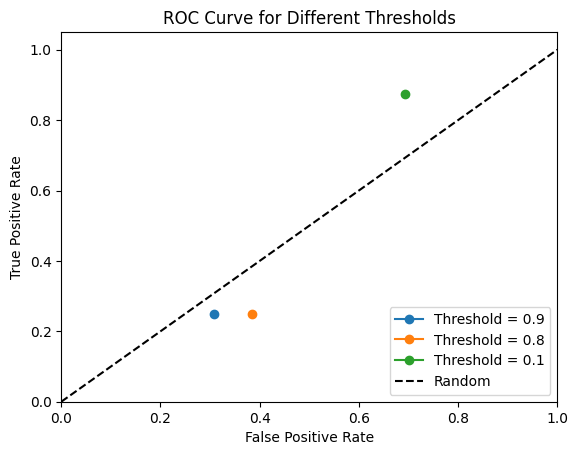

-------------------------------------
AUC: 0.46


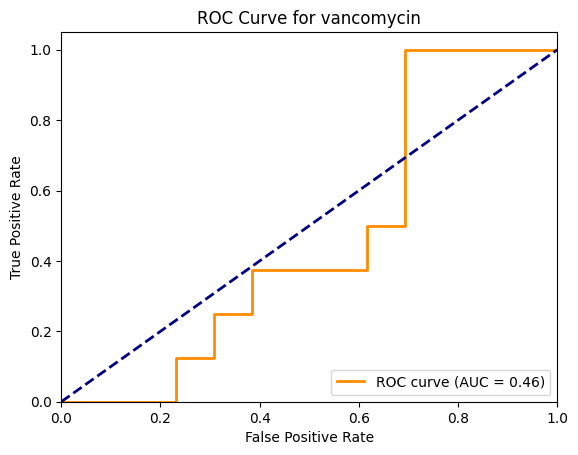

In [141]:
import matplotlib.pyplot as plt
drug = 'vancomycin'
drug_df,drug_genes = gene_per_drug(drug)
drug_train_for_model = create_update_gene_df(drug_df,list(drug_genes), drug)
# Step 1: Get selected_values for the current drug
selected_values = gene_antibiotic_df[drug][(gene_antibiotic_df[drug] != 0) & (gene_antibiotic_df[drug] != -1)]

# Step 2: Build Y_pred for the current drug
Y_pred = (selected_values > 0.9).astype(int)

# Step 3: Build Y_true for the current drug
Y_true = pd.Series(0, index=Y_pred.index)

# Set values in Y_true for genes in val_drug['Gene family']
for gene in Y_pred.index.intersection(val_drug['Gene family']):
        Y_true[gene] = 1

# Check if there are rows in drug_train_for_model where gene is 1 and label is 0
for gene in Y_pred.index:
    if Y_true[gene] == 0 and ((drug_train_for_model[gene] == 1) & (drug_train_for_model['label'] == 0)).any():
        Y_true[gene] = 0
# Compute the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for ROC curve
# Set your desired threshold values
threshold_values = [0.9, 0.8, 0.1]

for threshold in threshold_values:
    # Calculate binary predictions based on the specific threshold
    Y_pred_threshold = (selected_values > threshold).astype(int)

    # ... your existing code to set Y_true ...

    # Calculate True Positive Rate (TPR) and False Positive Rate (FPR) at the specific threshold
    true_positives = np.sum((Y_true == 1) & (Y_pred_threshold == 1))
    false_positives = np.sum((Y_true == 0) & (Y_pred_threshold == 1))
    true_negatives = np.sum((Y_true == 0) & (Y_pred_threshold == 0))
    false_negatives = np.sum((Y_true == 1) & (Y_pred_threshold == 0))

    tpr = true_positives / (true_positives + false_negatives)
    fpr = false_positives / (false_positives + true_negatives)
    print(true_positives, false_positives,true_negatives,false_negatives)
    # Plot the ROC point for the specific threshold
    plt.plot(fpr, tpr, marker='o', label=f'Threshold = {threshold}')
# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Thresholds')
plt.legend(loc='lower right')
plt.show()

print('-------------------------------------')
# Compute the False Positive Rate (FPR), True Positive Rate (TPR), and thresholds for ROC curve
fpr, tpr, thresholds = roc_curve(Y_true, selected_values)

# Calculate the Area Under the Curve (AUC) for the ROC curve
roc_auc = auc(fpr, tpr)

print(f"AUC: {roc_auc:.2f}")
# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {drug}')
plt.legend(loc='lower right')
plt.show()
# accuracy = accuracy_score(Y_true, Y_pred)
# precision = precision_score(Y_true, Y_pred)
# recall = recall_score(Y_true, Y_pred)
# f1 = f1_score(Y_true, Y_pred)
# print(f"Drug: {drug}")
# print(f"Accuracy: {accuracy:.2f}")
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1-score: {f1:.2f}")
# print("\n")




In [118]:
bb = drug_train_for_model
bb.to_csv('vancomycin_drug_train_for_model_alldata.csv')

In [119]:
aa = gene_antibiotic_df[drug]
aa.to_csv('vancomycin_pred_alldata.csv')

In [142]:
# selected_values = aa[(aa != 0) & (aa != -1)]
# filtered_values = selected_values[selected_values.index.isin(val_drug['Gene family'])]
print(selected_values)

vansa     0.993847
vanza     0.174448
vana      0.034848
vanha     0.152073
oqxa      0.996306
vanra     0.948514
vanya     0.114552
vang      0.763593
dfra14    0.704961
vanxa     0.125917
mexa      0.887745
dfra17    0.999298
oqxb      0.014229
dfrg      0.000222
dfrf      0.154967
dfra12    0.996977
dfrc      0.183888
dfra10    0.001950
dfre      0.001205
dfra1     0.986076
mexe      0.749323
Name: vancomycin, dtype: float64


In [143]:
print(val_drug)

    Gene family    Subclass
544        vana  vancomycin
556        vang  vancomycin
557       vanha  vancomycin
575       vanra  vancomycin
586       vansa  vancomycin
608       vanxa  vancomycin
625       vanya  vancomycin
632       vanza  vancomycin


In [54]:
print(selected_values)

dfra5     0.999809
dfra7     0.999440
oqxa      0.027315
dfra27    0.737019
dfra14    0.999170
dfra16    0.998257
dfra17    0.999921
oqxb      0.032517
dfrg      0.998768
dfra8     0.998096
dfra12    0.999917
dfra1     0.999950
Name: trimethoprim, dtype: float64


In [55]:
print(val_drug)

    Gene family      Subclass
306       dfra1  trimethoprim
308      dfra12  trimethoprim
309      dfra14  trimethoprim
311      dfra16  trimethoprim
312      dfra17  trimethoprim
317      dfra23  trimethoprim
321      dfra27  trimethoprim
327       dfra5  trimethoprim
330       dfra7  trimethoprim
331       dfra8  trimethoprim
338        dfrg  trimethoprim
842      dfra36  trimethoprim


In [56]:
Y_pred

dfra5     1
dfra7     1
oqxa      0
dfra27    0
dfra14    1
dfra16    1
dfra17    1
oqxb      0
dfrg      1
dfra8     1
dfra12    1
dfra1     1
Name: trimethoprim, dtype: int64

In [57]:
print(Y_true)

dfra5     1
dfra7     1
oqxa      0
dfra27    1
dfra14    1
dfra16    1
dfra17    1
oqxb      0
dfrg      1
dfra8     1
dfra12    1
dfra1     1
dtype: int64


In [58]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(Y_true, Y_pred)
precision = precision_score(Y_true, Y_pred)
recall = recall_score(Y_true, Y_pred)
f1 = f1_score(Y_true, Y_pred)
print(f"Drug: {drug}")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print("\n")

Drug: trimethoprim
Accuracy: 0.92
Precision: 1.00
Recall: 0.90
F1-score: 0.95




In [341]:
# strep_pred = gene_antibiotic_df[drug]
# # strep_pred.to_csv('trimethoprim_pred_alldata.csv')
# selected_values = strep_pred[(strep_pred != 0) & (strep_pred != -1)]
# filtered_values = selected_values[selected_values.index.isin(val_drug['Gene family'])]
# print(selected_values)

aada2       0.940633
aph3iib     0.180771
ant3iia     0.000004
aph3vi      0.142157
dfrc        0.078080
aac3iia     0.996165
aph4ia      0.745322
aac6ib3     0.429344
dfra16      0.999893
aada22      0.999999
aac6ib      0.489577
mexe        0.188463
aac3iie     0.267240
mexx        0.216684
dfra15      0.999996
aac6ib4     0.913355
aac3id      0.999726
rmtc        0.429936
mexa        0.135967
aac3iv      0.787854
aph6id      0.362423
dfra8       0.041253
oqxb        0.000843
aph3iiia    0.559045
aac3via     0.891152
aada12      0.999971
ant2ia      0.023482
aac2iia     0.000008
aada6       0.998862
oqxa        0.407336
aada15      0.999866
aph6ic      0.020294
dfra17      0.067657
aac6ibcr    0.065812
aph3iia     0.010021
aph3ia      0.053150
dfra27      0.340501
aada16      0.518817
dfrg        0.540301
arma        0.378146
aada25      0.987919
aac3iid     0.663348
aph3ib      0.626161
dfra1       0.434153
ant6ia      0.445780
dfrf        0.000031
dfrb3       0.000076
ant9ia      0

In [345]:
# print(len(filtered_values))
# print(len(val_drug))

18
20


In [76]:
len(problematic_drugs)

35

,ceftiofur,cefalexin,doxycycline,neomycin,ticarcillin,rifampin,zoliflodacin,fosfomycin-glucose-6-phosphate,ampicillin-sulbactam,chloramphenicol,...,imipenem-relebactam,erythromycin,carbenicillin,mupirocin,enrofloxacin,colistin,plazomicin,ciprofloxacin,vancomycin,Imipenem-EDTA-PA
blaPDC-19b,-1.0,-1,-1.0,-1,-1,-1.0,-1,-1,-1.0,-1.0,...,-1,-1.0,-1,-1.0,-1,-1.0,-1,0.0,-1.0,-1
ant(6)-Ia,-1.0,-1,0.0,-1,-1,0.0,-1,-1,0.0,0.0,...,-1,0.0,-1,0.0,-1,0.0,-1,0.0,0.0,-1
blaOXA-120,-1.0,-1,-1.0,-1,-1,-1.0,-1,-1,0.0,-1.0,...,-1,-1.0,-1,-1.0,-1,0.0,-1,0.0,-1.0,-1
mef(C),-1.0,-1,-1.0,-1,-1,-1.0,-1,-1,-1.0,0.0,...,-1,-1.0,-1,-1.0,-1,0.0,-1,0.0,-1.0,-1
blaEC,0.0,-1,0.0,-1,-1,0.0,-1,-1,0.0,0.0,...,-1,0.0,-1,-1.0,-1,0.0,-1,0.0,0.0,0
blaOXA-624,-1.0,-1,-1.0,-1,-1,-1.0,-1,-1,-1.0,-1.0,...,-1,0.0,-1,-1.0,-1,-1.0,-1,0.0,-1.0,-1
aadA10,-1.0,-1,-1.0,-1,-1,-1.0,-1,-1,0.0,-1.0,...,-1,-1.0,-1,-1.0,-1,-1.0,-1,-1.0,-1.0,0
lin,-1.0,-1,-1.0,-1,-1,0.0,-1,-1,-1.0,0.0,...,-1,0.0,-1,-1.0,-1,-1.0,-1,-1.0,0.0,-1
sat2,0.0,-1,0.0,-1,-1,-1.0,-1,-1,0.0,0.0,...,-1,-1.0,-1,-1.0,-1,0.0,-1,0.0,-1.0,0
blaCTX-M-134,-1.0,-1,-1.0,-1,-1,-1.0,-1,-1,-1.0,-1.0,...,-1,-1.0,-1,-1.0,-1,-1.0,-1,0.0,-1.0,-1


In [84]:
gene_antibiotic_df.head(10)

,levofloxacin,oxacillin,aztreonam,ceftiofur,cefotaxime-clavulanic acid,meropenem,cefalexin,benzylpenicillin,oxytetracycline,mupirocin,...,rifampin,streptomycin,synercid,ceftolozane-tazobactam,sulfonamide,imipenem-relebactam,fusidic acid,amoxicillin-clavulanic acid,quinupristin-dalfopristin,doxycycline
blaoxa493,-1.0,-1,-1.0,-1.0,-1,-1.0,-1,-1,-1,-1,...,-1.0,-1.0,-1.0,-1,-1,-1,-1,-1,-1,-1.0
cata1,0.0,0,0.0,0.0,0,0.0,-1,-1,-1,-1,...,0.0,0.0,-1.0,0,-1,-1,-1,0,-1,0.0
blaimp18,0.0,-1,0.0,-1.0,0,0.0,-1,-1,-1,-1,...,-1.0,-1.0,-1.0,0,-1,-1,-1,-1,-1,-1.0
blahmb,0.0,-1,0.0,-1.0,-1,0.0,-1,-1,-1,-1,...,-1.0,-1.0,-1.0,0,-1,-1,-1,-1,-1,-1.0
blaoxa623,-1.0,-1,-1.0,-1.0,-1,-1.0,-1,-1,-1,-1,...,-1.0,-1.0,-1.0,-1,-1,-1,-1,-1,-1,-1.0
qnrs,0.0,-1,0.0,-1.0,0,0.0,-1,-1,-1,-1,...,-1.0,0.0,-1.0,0,-1,-1,-1,0,-1,-1.0
oqxb14,0.0,-1,0.0,-1.0,-1,0.0,-1,-1,-1,-1,...,-1.0,-1.0,-1.0,0,-1,-1,-1,0,-1,-1.0
gyrae87g,0.0,-1,-1.0,-1.0,-1,-1.0,-1,-1,-1,-1,...,0.0,-1.0,-1.0,-1,-1,-1,-1,-1,-1,0.0
blacmy42,0.0,-1,0.0,-1.0,-1,0.0,-1,-1,-1,-1,...,-1.0,-1.0,-1.0,0,-1,-1,-1,0,-1,-1.0
oprdq142stop,0.0,-1,0.0,-1.0,-1,0.0,-1,-1,-1,-1,...,-1.0,-1.0,-1.0,-1,-1,-1,-1,-1,-1,-1.0


In [85]:
gene_antibiotic_df_copy.shape

(1209, 114)

In [88]:
gene_antibiotic_df_copy = gene_antibiotic_df_copy.loc[:, (gene_antibiotic_df_copy != -1.0).any(axis=0)]
gene_antibiotic_df_copy.shape

(1209, 72)

In [89]:
gene_antibiotic_df_copy.head(10)

,levofloxacin,oxacillin,aztreonam,ceftiofur,cefotaxime-clavulanic acid,meropenem,mupirocin,ciprofloxacin,clindamycin,cefpodoxime,...,telithromycin,piperacillin-tazobactam,cephalothin,rifampin,streptomycin,synercid,ceftolozane-tazobactam,fusidic acid,amoxicillin-clavulanic acid,doxycycline
blaOXA-493,-1.0,-1,-1.0,-1.0,-1,-1.0,-1,0.0,0.0,-1,...,0,-1,-1,-1.0,-1.0,-1.0,-1,-1,-1,-1.0
catA1,0.0,0,0.0,0.0,0,0.0,-1,0.0,-1.0,0,...,-1,0,0,0.0,0.0,-1.0,0,-1,0,0.0
blaIMP-18,0.0,-1,0.0,-1.0,0,0.0,-1,0.0,-1.0,-1,...,-1,0,-1,-1.0,-1.0,-1.0,0,-1,-1,-1.0
blaHMB,0.0,-1,0.0,-1.0,-1,0.0,-1,0.0,-1.0,-1,...,-1,0,-1,-1.0,-1.0,-1.0,0,-1,-1,-1.0
blaOXA-623,-1.0,-1,-1.0,-1.0,-1,-1.0,-1,0.0,0.0,-1,...,0,-1,-1,-1.0,-1.0,-1.0,-1,-1,-1,-1.0
qnrS,0.0,-1,0.0,-1.0,0,0.0,-1,0.0,-1.0,0,...,-1,0,0,-1.0,0.0,-1.0,0,-1,0,-1.0
oqxB14,0.0,-1,0.0,-1.0,-1,0.0,-1,0.0,-1.0,0,...,-1,0,0,-1.0,-1.0,-1.0,0,-1,0,-1.0
gyrA_E87G,0.0,-1,-1.0,-1.0,-1,-1.0,-1,-1.0,-1.0,-1,...,-1,-1,-1,0.0,-1.0,-1.0,-1,-1,-1,0.0
blaCMY-42,0.0,-1,0.0,-1.0,-1,0.0,-1,0.0,-1.0,-1,...,-1,0,-1,-1.0,-1.0,-1.0,0,-1,0,-1.0
oprD_Q142STOP,0.0,-1,0.0,-1.0,-1,0.0,-1,0.0,-1.0,-1,...,-1,0,-1,-1.0,-1.0,-1.0,-1,-1,-1,-1.0


In [91]:
gene_antibiotic_df_copy.to_csv("results_19_07.csv",index=True, index_label=False)